## Importing Libraries

In [1]:
library(forecast)
library(glmnet)
library(repr)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: Matrix

Loaded glmnet 4.1-2



### Setting Plot Size

In [2]:
options(repr.plot.width = 10, repr.plot.height = 10)

## Importing Data

In [3]:
data = read.csv(file = "data.csv")
test_data = read.csv(file ="testdata_vp.csv")
head(data)
head(test_data)
x= which(data$Solar_Irradiance_Wm2> 0,arr.ind = FALSE) # times where solar irrdence is not 0 
length(x)

,X,Time,Speed_ms,Temperature_C,Humidity,Solar_Irradiance_Wm2,Power_Watt
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2020-01-09 10:00:00,0.743,-3.092,43.48,59.48,-0.69527077
2,2,2020-01-09 10:10:00,0.458,-2.813,42.88,60.62,-0.26894369
3,3,2020-01-09 10:20:00,0.350,-2.219,41.58,66.71,-0.03266857
4,4,2020-01-09 10:30:00,0.598,-1.933,40.30,66.54,0.39081452
5,5,2020-01-09 10:40:00,0.809,-2.249,40.23,64.71,-0.47008277
6,6,2020-01-09 10:50:00,0.822,-2.279,40.18,69.12,0.60388749


,X,Time,Speed_ms,Temperature_C,Humidity,Solar_Irradiance_Wm2,Power_Watt
,<int>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<lgl>
1,1,1/12/2020 2:30,NA,18.81,80.50,0,NA
2,2,1/12/2020 2:40,NA,19.24,78.47,0,NA
3,3,1/12/2020 2:50,NA,19.45,77.84,0,NA
4,4,1/12/2020 3:00,NA,19.25,79.97,0,NA
5,5,1/12/2020 3:10,NA,19.15,80.70,0,NA
6,6,1/12/2020 3:20,NA,19.24,80.50,0,NA


[1] 153

## Exploring the Data

### Checking the correlation between all features

In [4]:
cor(data[3:7]) ## check correlation between variables

,Speed_ms,Temperature_C,Humidity,Solar_Irradiance_Wm2,Power_Watt
Speed_ms,1.00000000,0.73863227,0.1936181,-0.01579759,0.93408094
Temperature_C,0.73863227,1.00000000,0.4966482,-0.08514597,0.70508284
Humidity,0.19361809,0.49664817,1.0000000,-0.47244713,0.22154504
Solar_Irradiance_Wm2,-0.01579759,-0.08514597,-0.4724471,1.00000000,-0.01881058
Power_Watt,0.93408094,0.70508284,0.2215450,-0.01881058,1.00000000


### Checking Different Features Correlation with Wind Speed

In [5]:
print(paste('Solar_Irradiance_Day:',cor(data$Speed_ms[x], data$Solar_Irradiance_Wm2[x])))
print(paste('Humidity:', cor(data$Speed_ms,data$Humidity)))
print(paste('Temperature:', cor(data$Speed_ms, data$Temperature_C)))
print(paste('Power:',cor(data$Speed_ms,data$Power_Watt)))
print(paste('Temperature_Day:', cor(data$Speed_ms[x], data$Temperature_C[x])))
print(paste('Humidity_Day:',cor(data$Speed_ms[x],data$Humidity [x])))

cor_temp = cor_hum= cor_sol=vector(length= 10)

for (i in 1:10){
  cor_temp [i]= cor(data$Speed_ms, (data$Temperature_C)^i)
  cor_hum [i] = cor(data$Speed_ms, (data$Humidity)^i)
  cor_sol [i] = cor(data$Speed_ms[x], (data$Solar_Irradiance_Wm2[x])^i)
}

[1] "Solar_Irradiance_Day: -0.10127008543078"
[1] "Humidity: 0.193618093194276"
[1] "Temperature: 0.73863227053936"
[1] "Power: 0.934080939593275"
[1] "Temperature_Day: 0.910468258749931"
[1] "Humidity_Day: 0.32214412976112"


### Plotting the correlations with wind speed of each feature

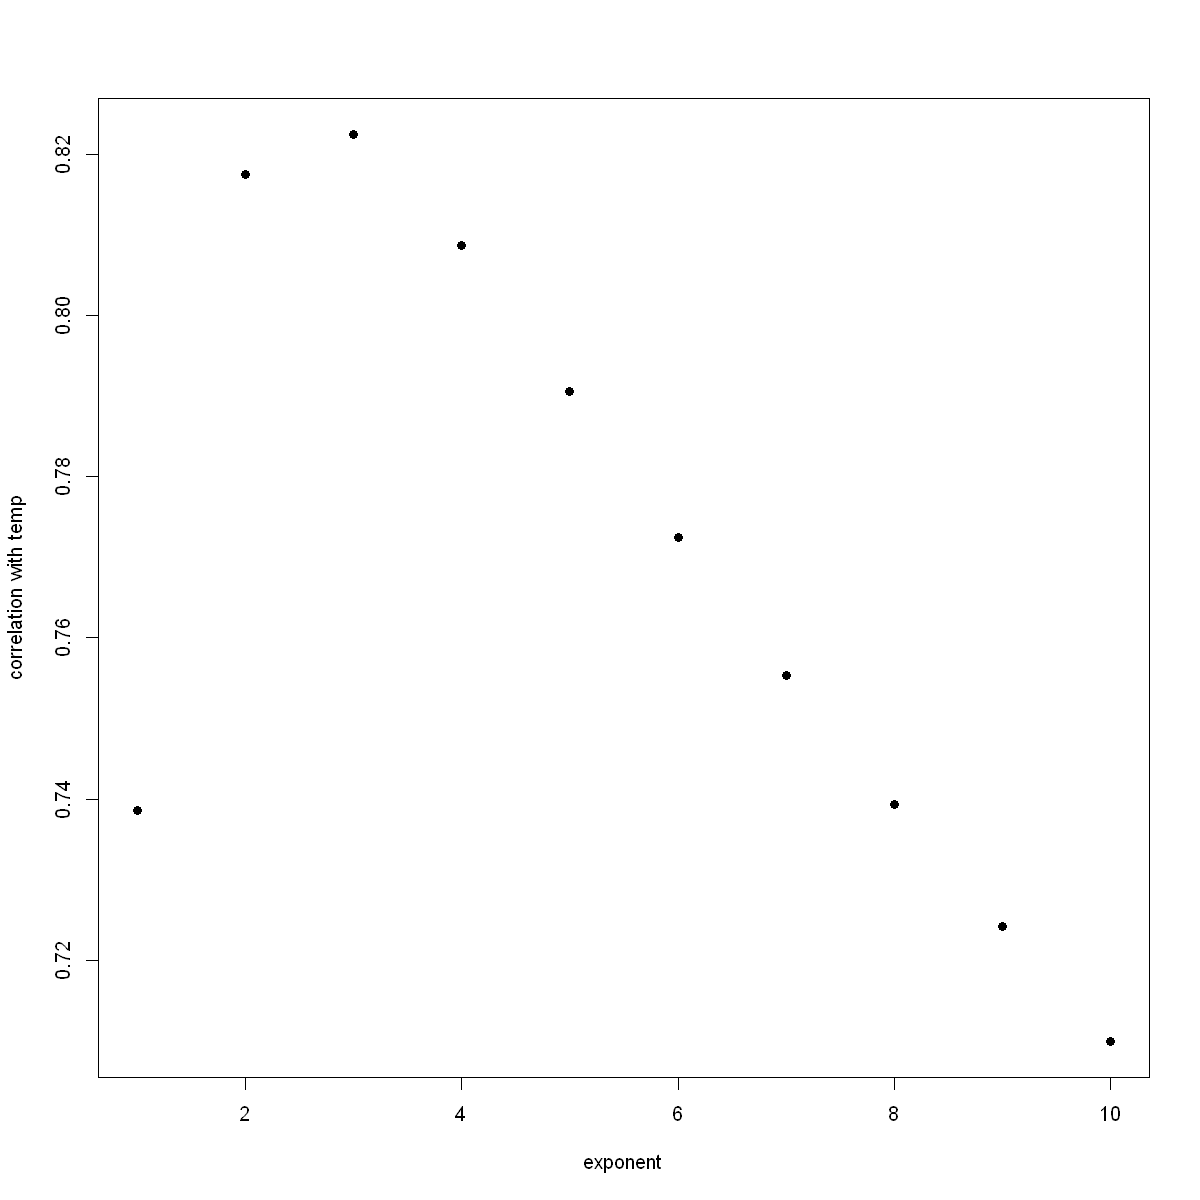

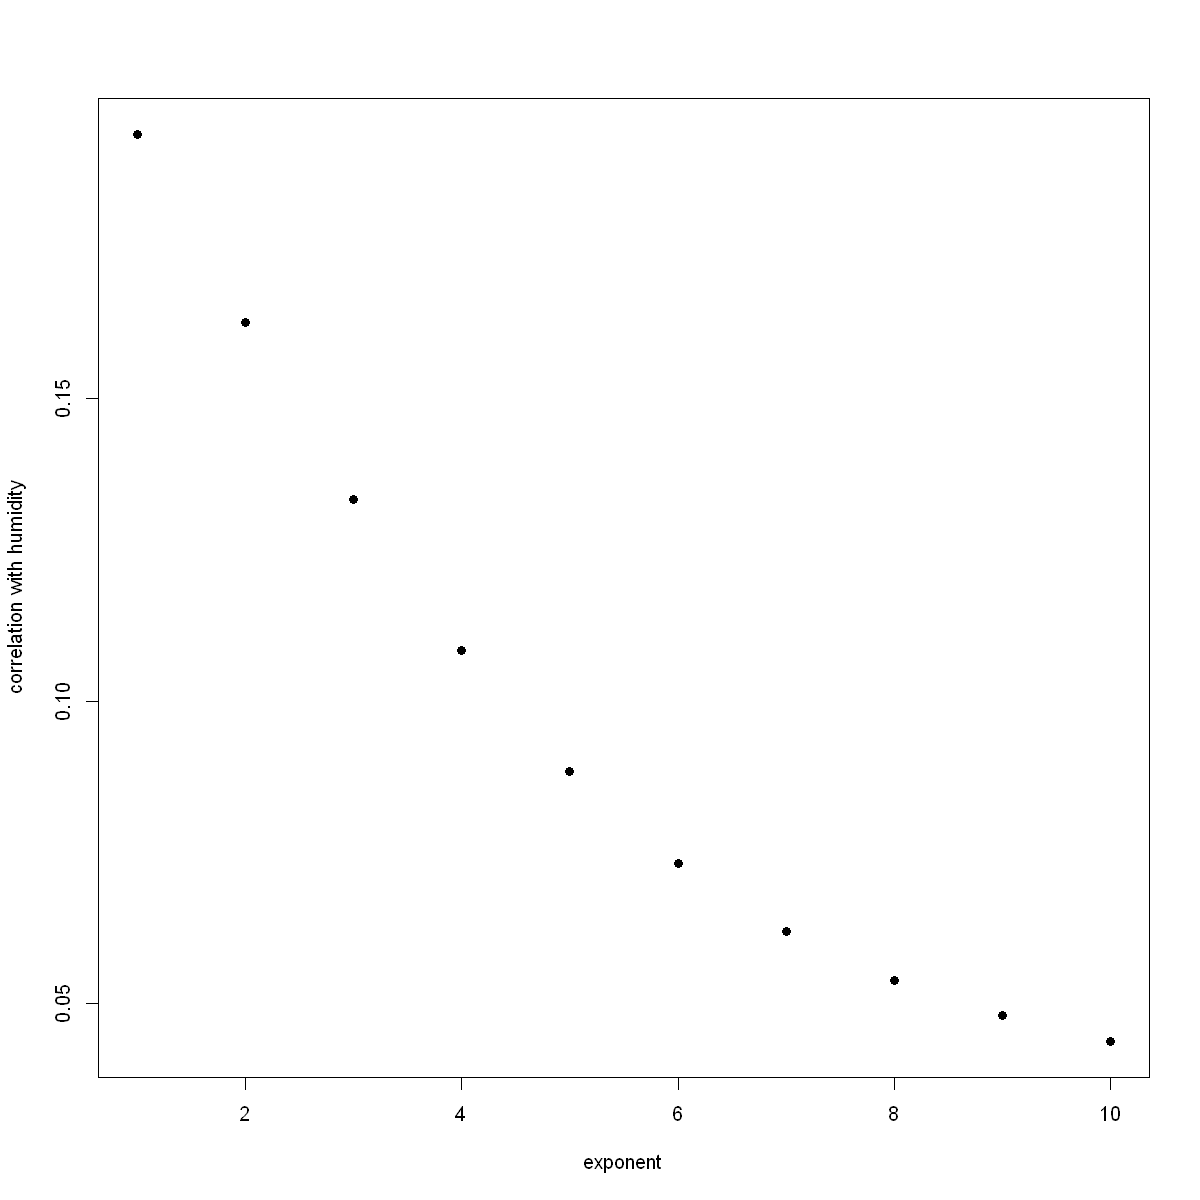

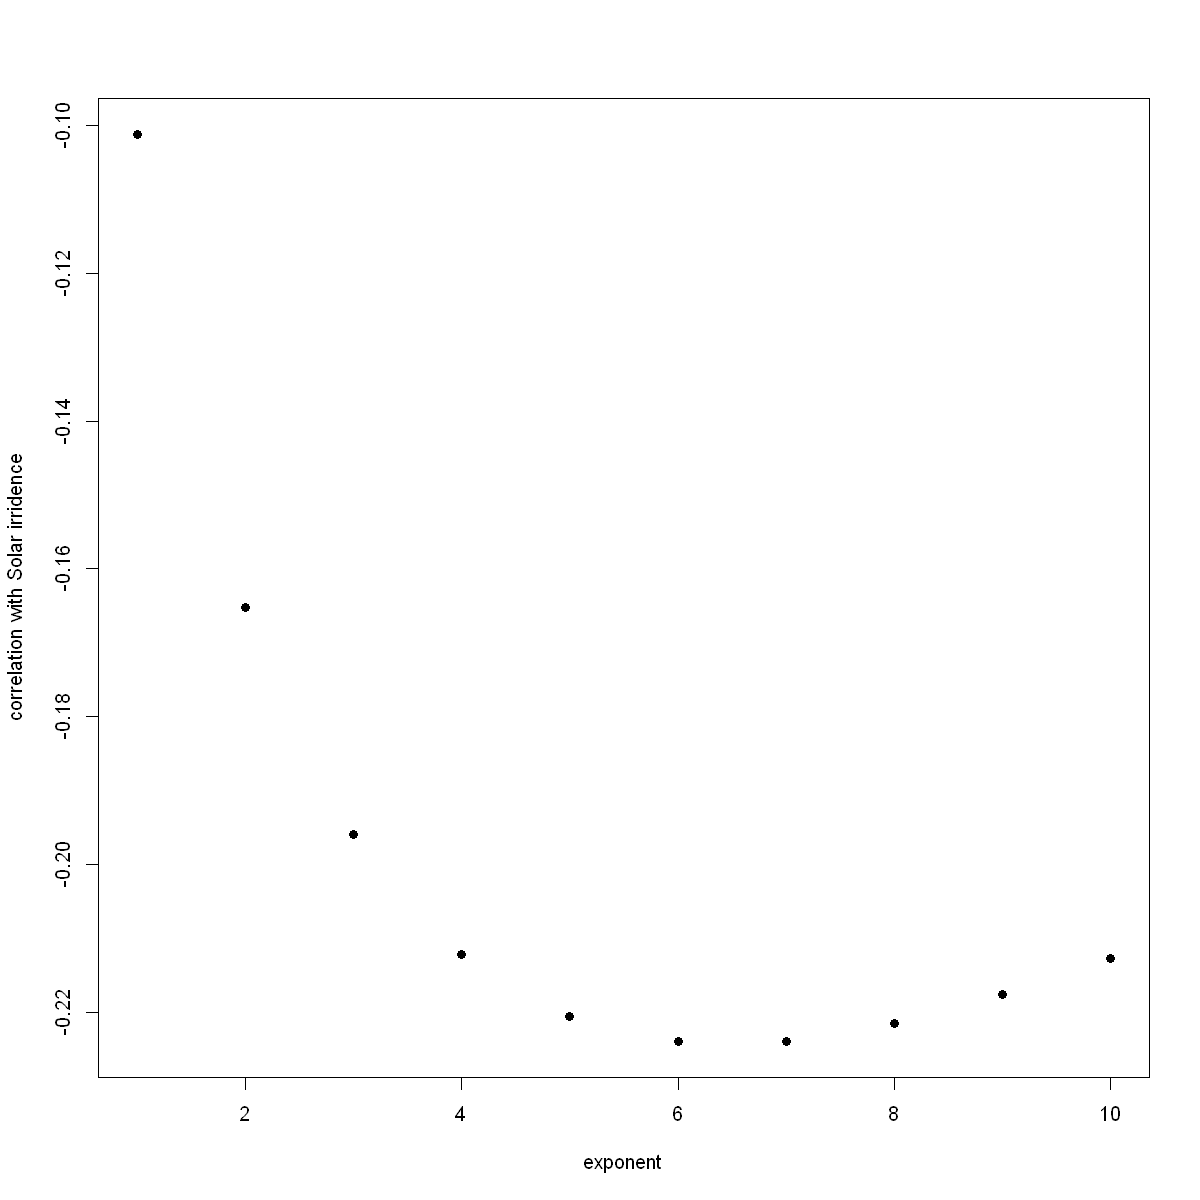

In [6]:
plot(seq(1,10,1),cor_temp, xlab="exponent", ylab = "correlation with temp", pch=19)

plot(seq(1,10,1),cor_hum, xlab="exponent", ylab = "correlation with humidity", pch=19)

plot(seq(1,10,1),cor_sol, xlab="exponent", ylab = "correlation with Solar irridence", pch=19)

__temp^3 has the best correlation with wind speed__

### Correlation with wind power

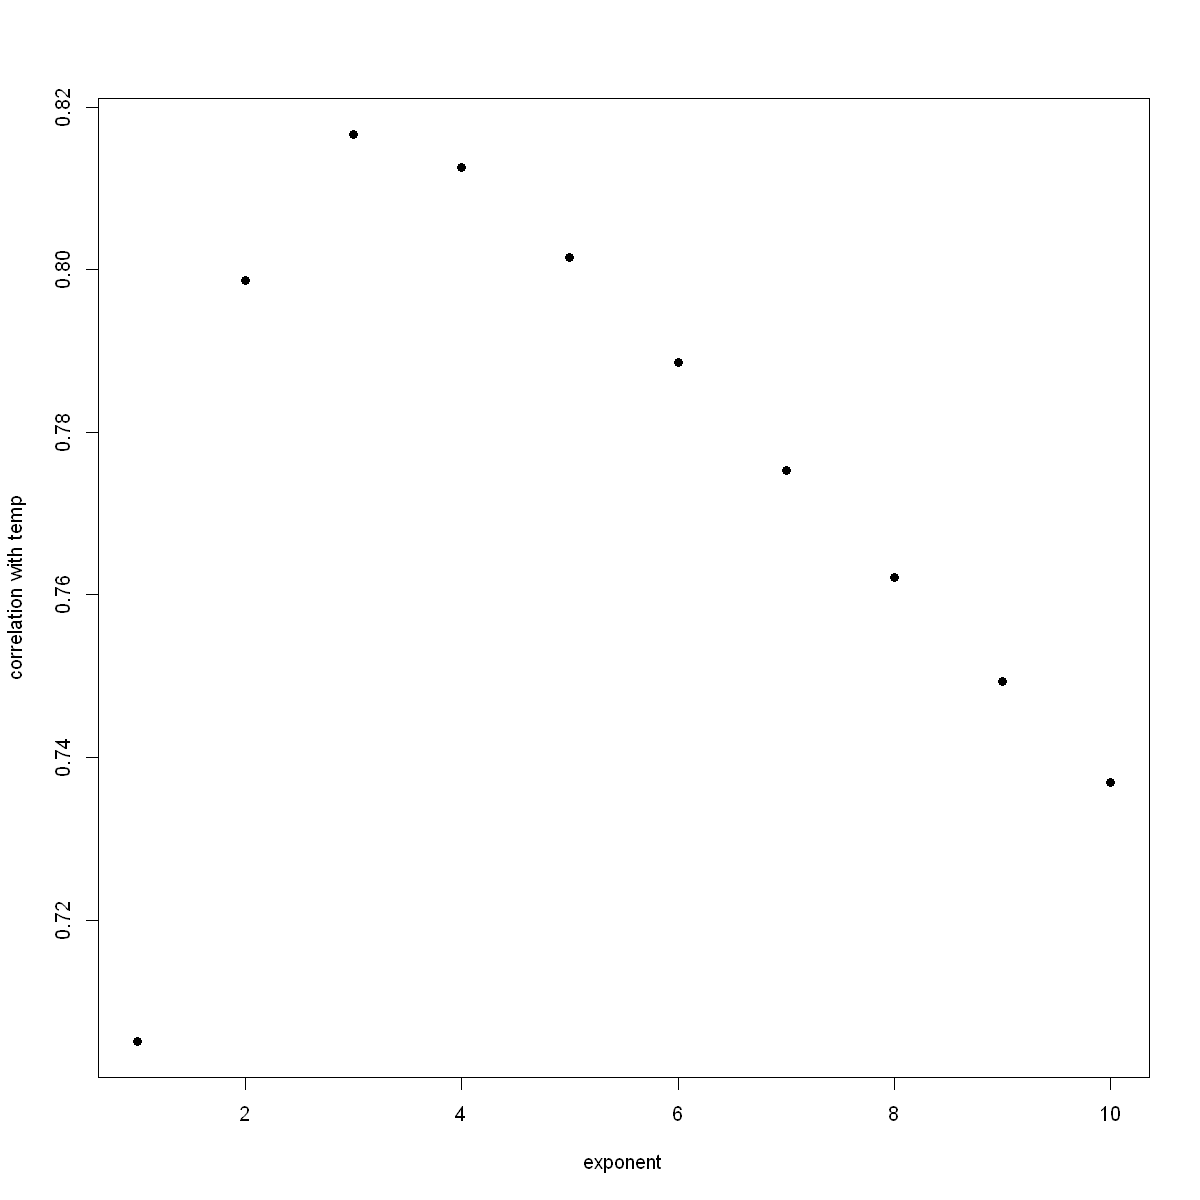

In [7]:
#checking correlation of temp with power
cor_temp2= vector(length=10)
for (i in 1:10){
  cor_temp2 [i]= cor(data$Power_Watt, (data$Temperature_C)^i)
}

plot(seq(1,10,1),cor_temp2, xlab="exponent", ylab = "correlation with temp", pch=19)

### Using and  80-20 train/test split 

In [8]:
train.id = seq(1,round(length(data$Time) *.8,0),1)
test.id = seq(round(length(data$Time) *.8,0)+1,length(data$Time),1)

# checking if data split 20% for testing
length(test.id)/(length(train.id)+length(test.id))

[1] 0.1989664

In [9]:
train = data[train.id,]
test = data[test.id,]

z = length(train.id)

## Converting Features to Time Series

In [10]:
speed = ts(data$Speed_ms)
temp = ts(data$Temperature_C)
power = ts(data$Power_Watt)
hum = ts(data$Humidity)
solar = ts(data$Solar_Irradiance_Wm2)

## Training the models
Using ARIMA models to forecast future wind speed on the wind farm

In [11]:
mod1=auto.arima(y= speed[train.id], xreg= temp[train.id])
mod2=auto.arima(y= speed[train.id], xreg= I(temp[train.id]^3))
mod3=auto.arima(y= speed[train.id], xreg= cbind(temp[train.id], I(temp[train.id]^2), I(temp[train.id]^3)))

summary(mod1)
summary(mod2)
summary(mod3) 

Series: speed[train.id] 
Regression with ARIMA(1,1,1) errors 

Coefficients:
         ar1      ma1    xreg
      0.4298  -0.7327  0.1269
s.e.  0.1178   0.0897  0.0459

sigma^2 = 0.08877:  log likelihood = -62.9
AIC=133.81   AICc=133.94   BIC=148.74

Training set error measures:
                       ME      RMSE       MAE       MPE     MAPE     MASE
Training set -0.003471318 0.2960175 0.2216598 -25.09847 42.74073 0.987228
                     ACF1
Training set -0.009541061

Series: speed[train.id] 
Regression with ARIMA(1,0,1) errors 

Coefficients:
         ar1      ma1  intercept   xreg
      0.9216  -0.2496     0.8541  3e-04
s.e.  0.0257   0.0692     0.1805  1e-04

sigma^2 = 0.08812:  log likelihood = -62.08
AIC=134.16   AICc=134.35   BIC=152.84

Training set error measures:
                       ME      RMSE       MAE     MPE     MAPE      MASE
Training set 0.0009465757 0.2949348 0.2236182 -30.775 47.68073 0.9959502
                   ACF1
Training set 0.01463145

Series: speed[train.id] 
Regression with ARIMA(1,0,1) errors 

Coefficients:
         ar1      ma1  intercept    xreg1   xreg2   xreg3
      0.9315  -0.2911     0.5850  -0.1400  0.0291  -8e-04
s.e.  0.0280   0.0737     0.2399   0.0707  0.0112   4e-04

sigma^2 = 0.08667:  log likelihood = -58.5
AIC=131   AICc=131.37   BIC=157.16

Training set error measures:
                      ME      RMSE       MAE       MPE     MAPE      MASE
Training set 0.004082249 0.2915296 0.2208283 -32.39336 51.03732 0.9835245
                   ACF1
Training set 0.01800389

## Testing the models

In [12]:
fcast1 = forecast(object=mod1,h=length(test.id), xreg=temp[test.id])$mean
fcast2 = forecast(object=mod2,h=length(test.id), xreg=I(temp[test.id]^3))$mean
fcast3 = forecast(object=mod3, h=length(test.id), xreg= cbind(temp[test.id], I(temp[test.id]^2), I(temp[test.id]^3)))$mean
fcast4 = rep(data$Speed_ms[z],length(test.id))

In [13]:
head(fcast1)
head(fcast2)
head(fcast3)
head(fcast4)

A Time Series:
[1] 2.993099 3.021214 3.037650 3.038001 3.042872 3.048951

A Time Series:
[1] 3.108789 3.126410 3.157905 3.160619 3.185226 3.216333

A Time Series:
[1] 3.074126 3.069475 3.068532 3.061794 3.060467 3.061040

[1] 2.926 2.926 2.926 2.926 2.926 2.926

## Calculating the Normalized Root Mean Square Error for each forecast

In [14]:
#NRMSE 
100*sqrt(mean((fcast1 - test$Speed_ms)^2))/(max(train$Speed_ms,na.rm=T) - min(train$Speed_ms,na.rm=T))
100*sqrt(mean((fcast2 - test$Speed_ms)^2))/(max(train$Speed_ms,na.rm=T) - min(train$Speed_ms,na.rm=T))
100*sqrt(mean((fcast3 - test$Speed_ms)^2))/(max(train$Speed_ms,na.rm=T) - min(train$Speed_ms,na.rm=T))
100*sqrt(mean((fcast4 - test$Speed_ms)^2))/(max(train$Speed_ms,na.rm=T) - min(train$Speed_ms,na.rm=T))


[1] 19.77424

[1] 18.54581

[1] 19.79659

[1] 20.6148

### Plotting the Forecasts

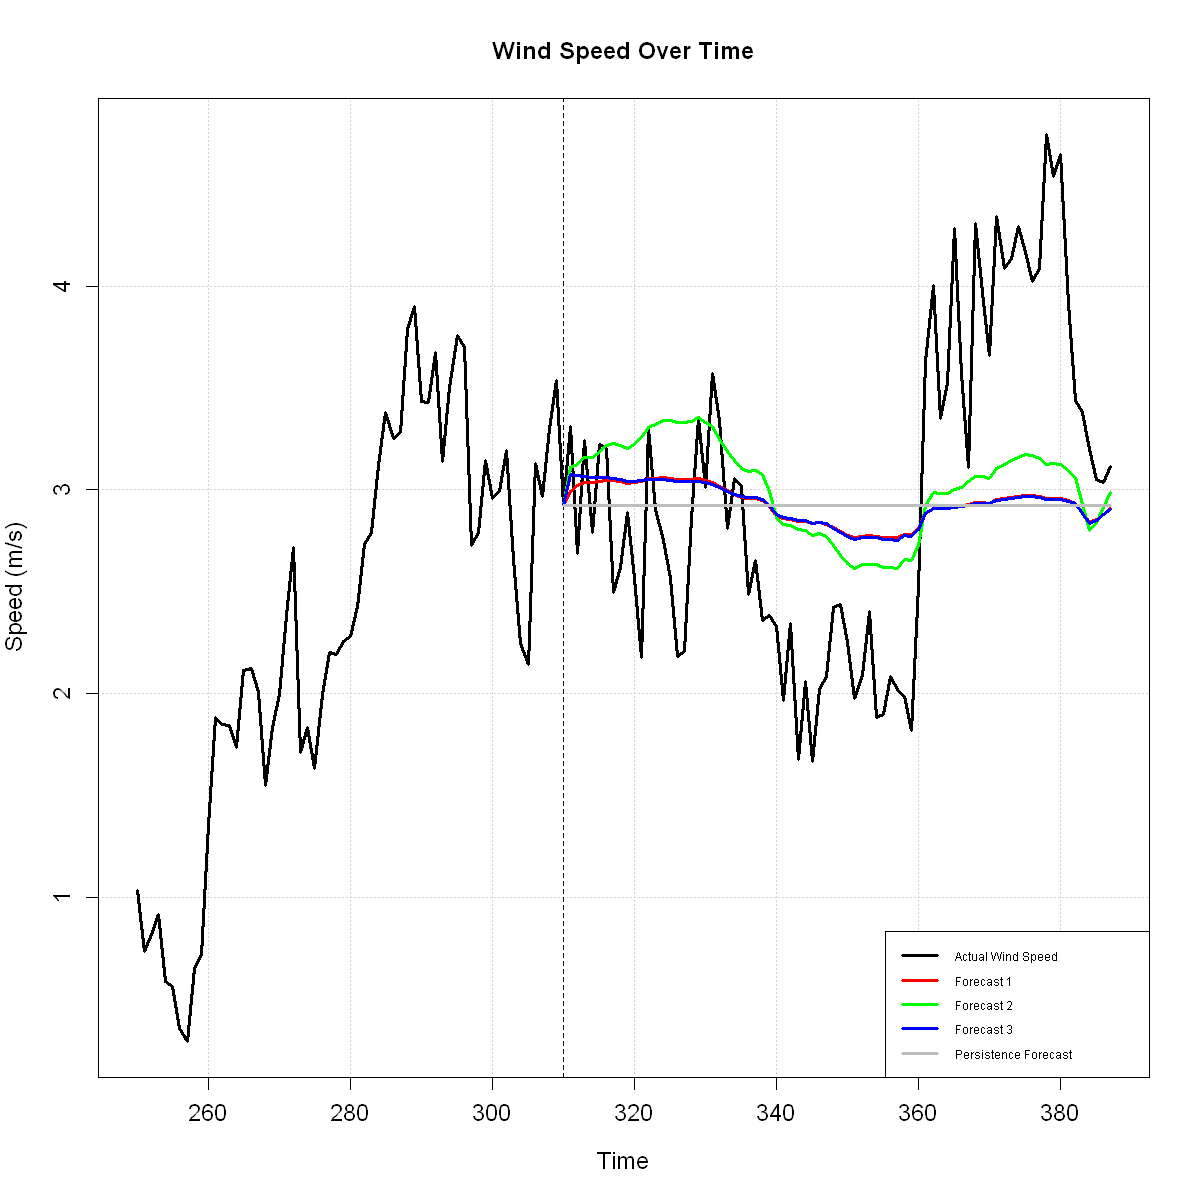

In [15]:
plot(seq(250,length(data$Time),1),data$Speed_ms[250:length(data$Time)],type="l",lwd=3,xlab="Time",panel.first=grid(),ylab="Speed (m/s)", main="Wind Speed Over Time",cex=1.2,cex.lab=1.2,cex.axis=1.2)
abline(v=z,lty=2)
lines(seq(z,length(data$Time),1),c(data$Speed_ms[z],fcast1),col="red",lwd=3)
lines(seq(z,length(data$Time),1),c(data$Speed_ms[z],fcast2),col="green",lwd=3)
lines(seq(z,length(data$Time),1),c(data$Speed_ms[z],fcast3),col="blue",lwd=3)
lines(seq(z,length(data$Time),1),c(data$Speed_ms[z],fcast4),col="gray",lwd=3)
legend(legend=c("Actual Wind Speed","Forecast 1","Forecast 2", "Forecast 3", "Persistence Forecast"), 
       col=c("black","red", "green", "blue" , "gray"),"bottomright", lwd=3, cex=0.6)

## Final Forecast

In [16]:
fin.mod = auto.arima(y = speed, xreg= I(temp^3))
summary(fin.mod)

Series: speed 
Regression with ARIMA(1,0,1) errors 

Coefficients:
         ar1      ma1  intercept   xreg
      0.9282  -0.2896     0.7658  4e-04
s.e.  0.0224   0.0609     0.1970  1e-04

sigma^2 = 0.1006:  log likelihood = -103.38
AIC=216.76   AICc=216.92   BIC=236.55

Training set error measures:
                       ME      RMSE       MAE       MPE     MAPE      MASE
Training set 0.0001020993 0.3154772 0.2391574 -24.06912 39.79665 0.9636798
                   ACF1
Training set 0.01948333

In [17]:
fin.ff= forecast(object=fin.mod,h=130, xreg=I(ts(test_data$Temperature_C)^3))$mean
head(fin.ff)

A Time Series:
[1] 3.279340 3.457935 3.548593 3.464192 3.423070 3.461721

### Creating a Persistence Forecast to Benchmark Against

In [18]:
fin.per =rep(speed[387],130) # persistence forecast
head(fin.per)

## Checking to see if the forecast are the same length
length(fin.per)
length(fin.ff)

[1] 3.113 3.113 3.113 3.113 3.113 3.113

[1] 130

[1] 130

### Plotting the ARIMA forecast vs persistence forecast

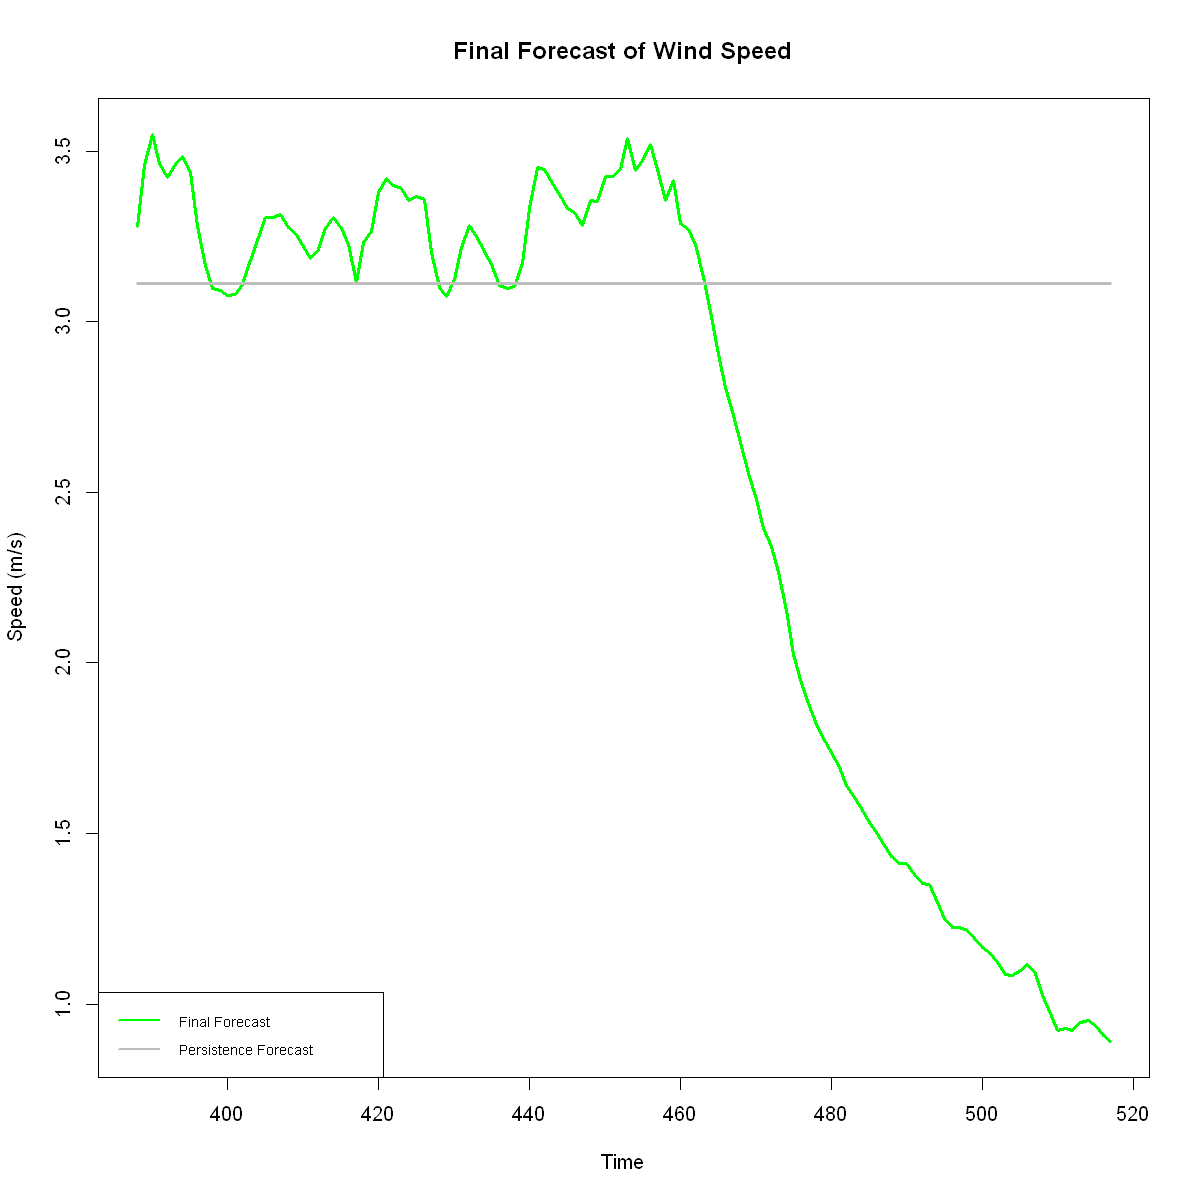

In [19]:
ts.plot(fin.ff, fin.per, col=c("green","gray"), gpars=list(lwd=3, main="Final Forecast of Wind Speed",xlab="Time",ylab="Speed (m/s)",cex=1.2,cex.lab=1.2,cex.axis=1.2))
legend(legend = c("Final Forecast","Persistence Forecast"), col=c("green", "gray"), "bottomleft", lwd=2, cex=0.7)

## Model Building

### Formulating the features and the target for the following model

In [20]:
df2 = data.frame(data$Speed_ms,data$Speed_ms^2,data$Speed_ms^3,data$Temperature_C,data$Power_Watt,data$Humidity)
y = data.matrix(df2[5])
head(y)

x = data.matrix(df2[1:4])
head(x)

data.Power_Watt
-0.69527077
-0.26894369
-0.03266857
0.39081452
-0.47008277
0.60388749


data.Speed_ms,data.Speed_ms.2,data.Speed_ms.3,data.Temperature_C
0.743,0.552049,0.41017241,-3.092
0.458,0.209764,0.09607191,-2.813
0.350,0.122500,0.04287500,-2.219
0.598,0.357604,0.21384719,-1.933
0.809,0.654481,0.52947513,-2.249
0.822,0.675684,0.55541225,-2.279


### Splitting train and test data (80:20) 


In [21]:
set.seed(123)
train.id = sample(1:length(df2$data.Speed_ms),size=0.8*length(df2$data.Speed_ms))
x.train = x[train.id,]
x.test = x[-train.id,]
y.train = y[train.id,]
y.test = y[-train.id,]

### Training Elastic-Net Regression Model

           Length Class  Mode     
lambda     100    -none- numeric  
cvm        100    -none- numeric  
cvsd       100    -none- numeric  
cvup       100    -none- numeric  
cvlo       100    -none- numeric  
nzero      100    -none- numeric  
call         6    -none- call     
name         1    -none- character
glmnet.fit  12    elnet  list     
lambda.min   1    -none- numeric  
lambda.1se   1    -none- numeric  
index        2    -none- numeric  

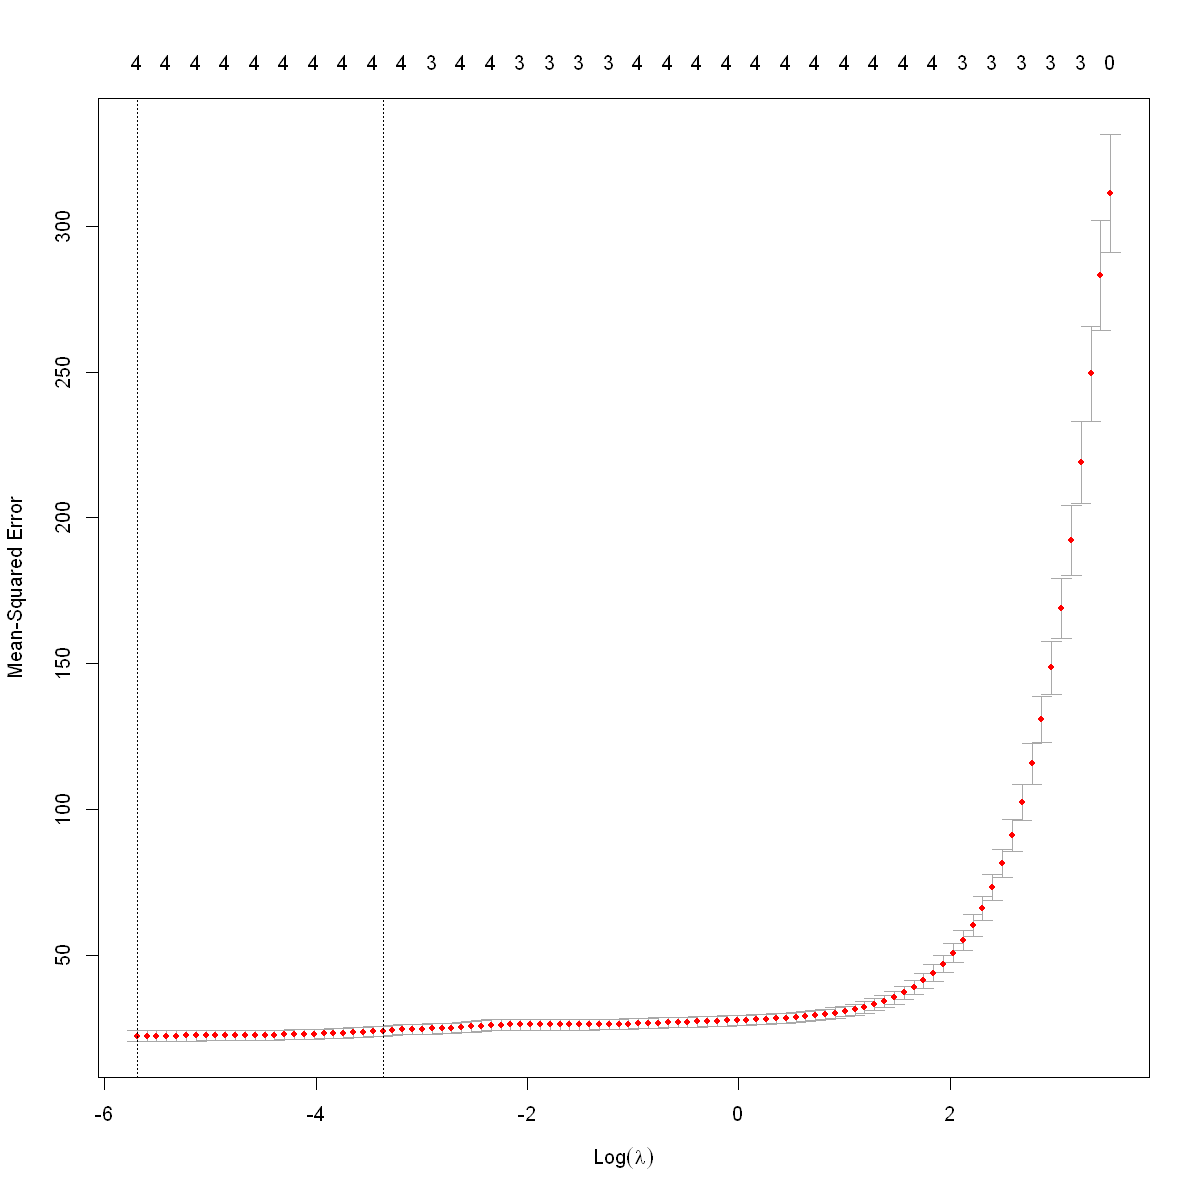

In [22]:
set.seed(123)
elastic.net =cv.glmnet(x.train, y.train, alpha = 0.5, type.measure = "mse", family="gaussian") # 10 fold cross validation
summary(elastic.net)
plot(elastic.net)

### Prediction and evaluation

In [23]:
pred.elastic = predict(elastic.net, s=elastic.net$lambda.1se, newx=x.test)
MSE.elastic = mean((y.test-pred.elastic)^2)

print(paste('Mean Square Error:', MSE.elastic))

# NRMSE of elastic-net model
NRMSE.elastic = 100*sqrt(MSE.elastic)/(max(x.train,na.rm=T) - min(x.train,na.rm=T)) 
print(paste('Normalized Root Mean Square Error:', NRMSE.elastic))

[1] "Mean Square Error: 15.4343039169961"
[1] "Normalized Root Mean Square Error: 3.81297973583338"


### Training the model on all the data

In [24]:
lam_elastic.net = elastic.net$lambda.1se
fin_elastic.net = glmnet(x, y, alpha = 0.5, family="gaussian")
coef_elastic.net = predict(fin_elastic.net, type = "coefficients", s=lam_elastic.net)
best_elastic.net = elastic.net$glmnet.fit
coef_elastic.net

5 x 1 sparse Matrix of class "dgCMatrix"
                           s1
(Intercept)        -2.0112601
data.Speed_ms      -1.4785065
data.Speed_ms.2     5.4336392
data.Speed_ms.3    -0.3914785
data.Temperature_C  0.1066052

## Final Prediction

### Refining the variables for final prediction

In [25]:
df_fin = data.frame(fin.ff, fin.ff^2, fin.ff^3, test_data$Temperature_C)
head(df_fin)
matrix_test = data.matrix(df_fin)
head(matrix_test)

,fin.ff,fin.ff.2,fin.ff.3,test_data.Temperature_C
,<dbl>,<dbl>,<dbl>,<dbl>
1,3.279340,10.75407,35.26627,18.81
2,3.457935,11.95732,41.34762,19.24
3,3.548593,12.59251,44.68569,19.45
4,3.464192,12.00062,41.57246,19.25
5,3.423070,11.71741,40.10951,19.15
6,3.461721,11.98351,41.48359,19.24


fin.ff,fin.ff.2,fin.ff.3,test_data.Temperature_C
3.279340,10.75407,35.26627,18.81
3.457935,11.95732,41.34762,19.24
3.548593,12.59251,44.68569,19.45
3.464192,12.00062,41.57246,19.25
3.423070,11.71741,40.10951,19.15
3.461721,11.98351,41.48359,19.24


### Prediction

In [26]:
fin_pred = predict(best_elastic.net, s=lam_elastic.net, newx= matrix_test)
head(fin_pred)

s1
39.73895
43.66914
45.69200
43.80791
42.89544
43.75275


### Plot of Power Predictions

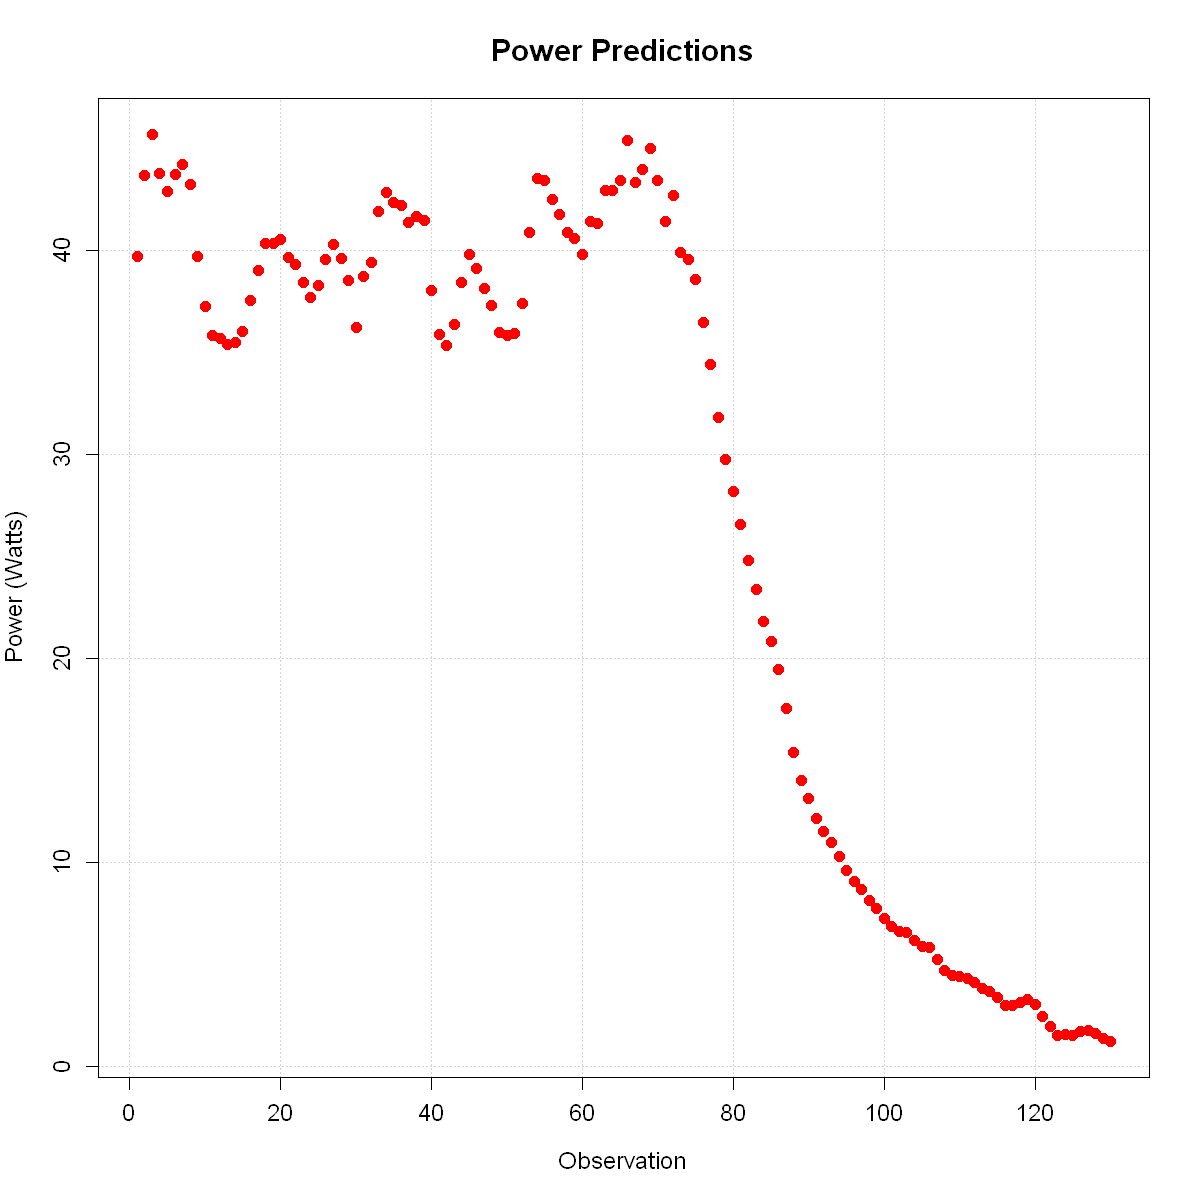

In [27]:
plot(fin_pred,xlab="Observation",ylab="Power (Watts)",cex.main= 1.5,cex=1.2,cex.axis=1.2,cex.lab=1.2,pch=19,col="red",panel.first=grid(), main= "Power Predictions")

### Storing the predictions

In [28]:
final = data.frame(fin.ff, fin_pred)
colnames(final) = c("Speed_ms","Power_Watt")
head(final)

,Speed_ms,Power_Watt
,<dbl>,<dbl>
1,3.279340,39.73895
2,3.457935,43.66914
3,3.548593,45.69200
4,3.464192,43.80791
5,3.423070,42.89544
6,3.461721,43.75275
